In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
%matplotlib inline
import warnings
from sklearn.feature_selection import RFECV
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a'
    )

In [325]:
raw = pd.read_csv('epi_r.csv')# read data
raw = raw.drop(['calories', 'protein', 'fat', 'sodium','title'],1)#drop nulls/non-numeric
raw.rating = np.where(raw.rating>4,1,0)#convert rating to binary at 4+
raw.columns = raw.columns.str.replace('[^a-zA-Z]', '')#replace space,non-alpha
_, i = np.unique(raw.columns, return_index=True)#list unique columns
raw = raw.iloc[:, i]#select unique columns


In [326]:
#create lists for some attribute examination.
#For each, attribute I will find out how often it occurs, what the odds are of it being a '0' recipe, 
#and of the number of occurances, what it the probabilty that it is a 1.
cols = [] #attribute name
odds_of_zero = [] # #0s/1s
present = [] #no of occurances
pct_good = [] #%of time was 1 good recipe when present
variance = [] #%present in data


#loop to compare the odds of getting rating = 0 vs rating 1
for col in raw.loc[:, ~(raw.columns).isin(['rating'])]:
    variance.append(raw[col].mean())
    odds = raw.loc[raw[col]==1] #locate entries where attribute value is 1
    cols.append(col)#append the attribute name
    present.append(len(odds.rating))#the occurance of attribute
    pct_good.append(odds.rating.mean())#percent good recipes when attribute present
    #in the case of zero occurance of good ratings
    if odds.rating.sum() == 0:
        odds_of_zero.append(100)
    # if sum() not 0, calculate odds.
    if odds.rating.sum() != 0:
        that = len(odds.rating)-odds.rating.sum()
        this = odds.rating.sum()
        odds_of_zero.append(that/this)
        
corrmat = raw.drop(['rating'],1).corr().abs()#create correlation matrix
c = corrmat.unstack().reset_index() #unstack the matrix        
d = c.loc[(c[0]!=1)&(c[0]>.40)] #look at attributes that correlate more that .4
d = d.rename(columns={0:'corr'})
corrgroup = d.groupby('level_0')['level_1'].value_counts()
#create a data frame to visualize the statistics of the attributes
pdf = pd.DataFrame()
pdf['col'] = cols
pdf['odds_of_zero'] = odds_of_zero
pdf['present'] = present
pdf['variance'] = variance
pdf['pct_good'] = pct_good
pdf['n_corrs>.40'] = corrgroup.groupby('level_0').describe().reset_index()['count']
pdf['avg_corr'] = d.groupby('level_0')['corr'].mean().reset_index()['corr']
pdf.fillna(0,inplace=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


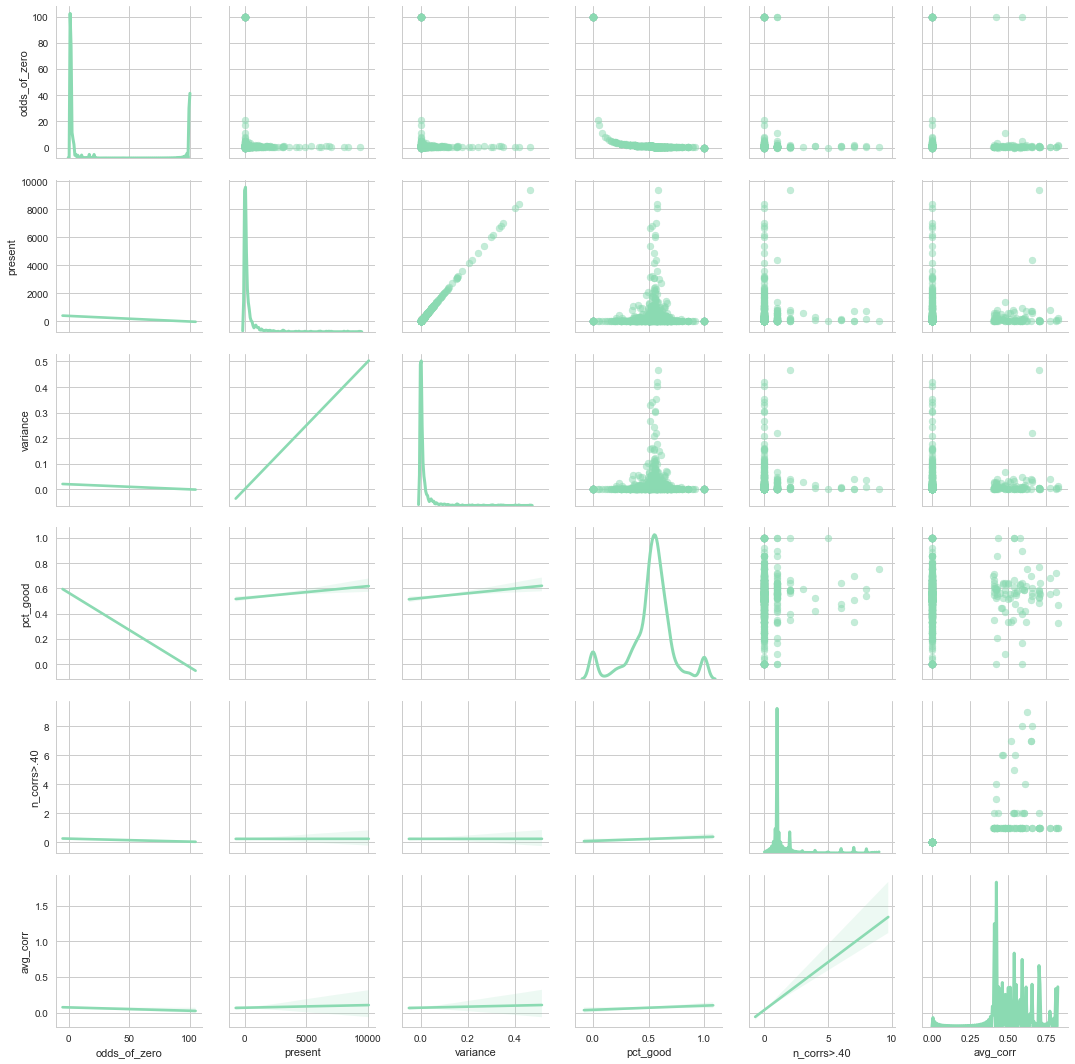

In [327]:
#A quick visuaization,
sns.set(style='whitegrid',palette='mako_r')
g = sns.PairGrid(pdf, diag_sharey=False)

g.map_upper(plt.scatter, alpha=.5)

g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [328]:
#Select data for the model
X = raw.drop(['rating'],1)
Y = raw.rating

In [329]:
#Use random forest to get a better idea of features to use
rfc = ensemble.RandomForestClassifier(n_estimators=30)#instatiate classifier
rfc.fit(X,Y) #fit the model
print(cross_val_score(rfc,X,Y,cv=5))
#create data frame to organize feature importances
feature_sigs = pd.DataFrame(
    sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), 
               X.columns), reverse=True))
feature_sigs.rename(columns={0:'sig',1:'feature'},inplace=True)#rename int columns
feature_sigs.head()

[0.64198454 0.63201197 0.64223386 0.64837905 0.63432277]


,sig,feature
0,0.0136,quickeasy
1,0.0116,bonapptit
2,0.0115,summer
3,0.0114,winter
4,0.0106,bake


In [330]:
best_atts = pd.DataFrame()
for i in range(1,10):
    X = raw.drop(['rating'],1)
    Y = raw.rating
    rfc = ensemble.RandomForestClassifier(n_estimators=i*10)
    rfc.fit(X,Y)
    feature_sigs = pd.DataFrame(
        sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), 
               X.columns), reverse=True))
    feature_sigs.rename(columns={0:'sig',1:'feature'},inplace=True)
    best_atts['n_ests {:0.2f}'.format(i*10)] = feature_sigs.feature

In [331]:
top_30 = best_atts[0:30]
top_30T = top_30.T
top_30T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
n_ests 10.00,quickeasy,bonapptit,summer,fall,bake,winter,gourmet,onion,tomato,vegetarian,...,garlic,citrus,side,ginger,dinner,dairy,kidneyfriendly,chicken,cheese,treenutfree
n_ests 20.00,quickeasy,summer,bonapptit,winter,bake,onion,vegetarian,fall,milkcream,gourmet,...,dairy,side,lemon,fruit,cheese,ginger,treenutfree,kidneyfriendly,citrus,sugarconscious
n_ests 30.00,quickeasy,bonapptit,summer,winter,bake,fall,onion,gourmet,tomato,vegetarian,...,garlic,lemon,fruit,side,ginger,sugarconscious,chill,cheese,kidneyfriendly,citrus
n_ests 40.00,quickeasy,summer,bonapptit,winter,bake,gourmet,vegetarian,fall,onion,tomato,...,dairy,lemon,side,fruit,sugarconscious,ginger,cheese,kidneyfriendly,citrus,chill
n_ests 50.00,quickeasy,bonapptit,summer,winter,bake,gourmet,vegetarian,onion,fall,herb,...,dairy,fruit,side,lemon,ginger,sugarconscious,citrus,cheese,treenutfree,nosugaradded
n_ests 60.00,quickeasy,bonapptit,summer,winter,gourmet,bake,vegetarian,onion,fall,herb,...,healthy,lemon,fruit,side,cheese,sauce,roast,ginger,citrus,chill
n_ests 70.00,quickeasy,bonapptit,summer,winter,gourmet,fall,bake,onion,vegetarian,kidfriendly,...,dairy,fruit,lemon,ginger,side,chill,cheese,citrus,sugarconscious,kidneyfriendly
n_ests 80.00,quickeasy,bonapptit,summer,winter,gourmet,bake,onion,fall,vegetarian,herb,...,dairy,fruit,lemon,side,cheese,ginger,kidneyfriendly,sugarconscious,citrus,chill
n_ests 90.00,quickeasy,summer,bonapptit,winter,bake,gourmet,fall,onion,vegetarian,tomato,...,egg,lemon,fruit,side,cheese,ginger,citrus,treenutfree,sugarconscious,dinner


In [332]:
final_atts = []
for col in top_30T:
    final_atts.append(top_30T[col].value_counts()[0:1].index[0]
)
final_atts

['quickeasy',
 'bonapptit',
 'summer',
 'winter',
 'bake',
 'gourmet',
 'vegetarian',
 'onion',
 'vegetarian',
 'herb',
 'herb',
 'saut',
 'wheatglutenfree',
 'kidfriendly',
 'saut',
 'milkcream',
 'spring',
 'garlic',
 'tomato',
 'healthy',
 'dairy',
 'lemon',
 'fruit',
 'side',
 'cheese',
 'ginger',
 'cheese',
 'kidneyfriendly',
 'citrus',
 'chill']

In [333]:
#that wasnt very productive...
# i am going to take the list from the 10 iteration with 90 estimaters
final_atts = top_30['n_ests 90.00']


In [334]:
# the assignment is to use up to 30 features.
#look at how the 30 most important features correlate with each other
first30 = raw[final_atts]
f30_corrmat = first30.corr()
f30_corrs = f30_corrmat.unstack().reset_index()
f30_corrs = f30_corrs.sort_values(by=0,ascending=False)
f30_corrs = f30_corrs.loc[(f30_corrs[0]!=1)&(f30_corrs[0]>.0001)]
f30_corrs.head(5)


,level_0,level_1,0
826,treenutfree,wheatglutenfree,0.552269
507,wheatglutenfree,treenutfree,0.552269
867,sugarconscious,treenutfree,0.417259
838,treenutfree,sugarconscious,0.417259
267,vegetarian,treenutfree,0.369924


In [335]:
#Not a lot of correlation

In [336]:
svc = SVC(kernel='linear')#instantiate classifier
X = raw[final_atts]
Y = raw.rating
svc.fit(X,Y)
print('Accuracy of the fit {}'.format(svc.score(X,Y)))
print('\n Cross Validation Score: ')
print(cross_val_score(svc,X,Y,cv=5))
      


Accuracy of the fit 0.5544085378017155

 Cross Validation Score: 
[0.55322862 0.56170531 0.54973822 0.55436409 0.55300574]


In [337]:
svc = SVC(kernel='rbf')#instantiate classifier
X = raw[final_atts]
Y = raw.rating
svc.fit(X,Y)
print('Accuracy of the fit {}'.format(svc.score(X,Y)))
print('\n Cross Validation Score: ')
print(cross_val_score(svc,X,Y,cv=5))

Accuracy of the fit 0.5730101735487731

 Cross Validation Score: 
[0.56369983 0.57217651 0.55646971 0.56683292 0.56747319]


In [338]:
scores =[]
for col in top_30:
    svc = SVC(kernel='rbf')#instantiate classifier
    X = raw[top_30[col]]
    Y = raw.rating
    svc.fit(X,Y)
    scores.append(cross_val_score(svc,X,Y,cv=3).mean())
scores = np.array(scores)
print(scores)
print(scores.mean())

[0.56657646 0.56084138 0.5608414  0.5608414  0.56074174 0.56193864
 0.5608414  0.5608414  0.56677597]
0.5622488660379309


In [339]:
predicted = svc.predict(X_test[final_atts])
actual = Y_test
print(pd.crosstab(predicted,actual))

rating     0     1
row_0             
0       1634  1216
1       3061  4115


In [340]:
trainsize = int(raw.shape[0] / 2)
test = raw.iloc[trainsize:, :].copy()
train = raw.iloc[:trainsize, :].copy()

Y_train = train.rating
X_train = train.drop(['rating'],1)

Y_test = test.rating
X_test = test.drop(['rating'],1)

In [341]:
scores = []
for col in top_30:
    ridge = linear_model.Ridge(alpha=1)
    X = raw[top_30[col]]
    Y = raw.rating
    ridge.fit(X,Y)
    scores.append(cross_val_score(ridge,X,Y,cv=3).mean())
scores = np.array(scores)
print(scores)
print(scores.mean())

[0.02254013 0.01897196 0.01728348 0.01728348 0.01900422 0.02079388
 0.01728348 0.01728348 0.02119848]
0.0190713967696609


In [342]:
scores =[]
for col in top_30:
    ridge = LogisticRegression(penalty='l2')
    X = raw[top_30[col]]
    Y = raw.rating
    ridge.fit(X,Y)
    scores.append(cross_val_score(ridge,X,Y,cv=3).mean())
scores = np.array(scores)
print(scores)
print(scores.mean())

[0.5706167  0.56742451 0.56562901 0.56562901 0.56722523 0.56602842
 0.56562901 0.56562901 0.56867151]
0.5669424891561925


In [343]:
scores =[]
for col in top_30:
    ridge = LogisticRegression(penalty='l1')
    X = raw[top_30[col]]
    Y = raw.rating
    ridge.fit(X,Y)
    scores.append(cross_val_score(ridge,X,Y,cv=3).mean())
scores = np.array(scores)
print(scores)
print(scores.mean())

[0.57131496 0.56692581 0.56592821 0.56592821 0.56752442 0.56667683
 0.56592821 0.56592821 0.56832256]
0.5671641583129241


In [344]:
scores =[]
for col in top_30:
    knn = KNeighborsClassifier(n_neighbors=10,weights = 'distance')
    X = raw[top_30[col]]
    Y = raw.rating
    knn.fit(X,Y)
    scores.append(cross_val_score(knn,X,Y,cv=3).mean())
scores = np.array(scores)
print(scores)
print(scores.mean())

[0.55660332 0.56054317 0.55276347 0.55171594 0.55505682 0.55296249
 0.5468283  0.55381083 0.55999404]
0.5544753738924797


In [345]:
predicted = knn.predict(X_test[final_atts])
actual = Y_test
print(pd.crosstab(predicted,actual))

rating     0     1
row_0             
0       4082  1251
1        613  4080


In [346]:
ridge = LogisticRegression(penalty='l1',C=0.045)
ridge.fit(X_train, Y_train)

LogisticRegression(C=0.045, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Using the top 30 attributes the random forest model gave us, the average score for the classifiers was 56-57%.
The data is packed with bias, for instance a person who is gluten free may rate a gluten free recipe abnormally high because they don't eat non-gluten items. Also, a alot of the variables have close to 1:1 odds with the binary 'rating'